## importing necessary libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os.path
import time
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import copy
import seaborn as sns
import pandas as pd


## connecting to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## configurations are used to have unified variables across the system
Batch size: 16 → Defines how many images are processed per training step.

Learning rate: 0.001 → Controls how much weights update per step.

Number of epochs: 10 → Number of passes through the dataset per client.

Number of clients: 8 → Can be adjusted to 4, 5, or 6.

Federated rounds: 5 → Number of times global aggregation (FedAvg) happens.

Image size: (224, 224) → Resize all images to this size.

Number of classes: 4 → Brain tumor classification (4 categories).

Device: "cpu" → Should be changed to "cuda" if a GPU is available.

Dataset paths: Locations of training and test images.

Normalization values: (normalize_mean & normalize_std) for standardizing images.

Dirichlet alpha: 10 → Controls how non-IID the client dataset splits are.

In [ ]:
config = {
    "batch_size": 16,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "num_clients": 8,
    "num_rounds": 20,
    "image_size": (224, 224),
    "num_classes": 4,
    "device":  torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dataset_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan",
    "train_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan/Training",
    "test_path": "/content/drive/My Drive/Colab Notebooks/MRI_Scan/Testing",
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225],
    "dir_alpha": 10,  # Dirichlet parameter for controlling distribution
}

## Image tranformations
Resizes images to 224x224

Applies random horizontal flips

Applies random rotation (±10 degrees) (helps model generalize better)

Converts images to tensors (PyTorch format)

Normalizes images using mean=[0.485, 0.456, 0.406] & std=[0.229, 0.224, 0.225] (standard ImageNet values).

In [ ]:
# Image transformations
data_transforms = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["normalize_mean"], std=config["normalize_std"])
])


## Loading Dataset

1- Defines a function load_dataset

2- Loads the training and test datasets

3- Prints the number of classes detected

In [ ]:
def load_dataset(data_path, transform):
    """Load dataset from the given path."""
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    return dataset

# Load datasets
print("Loading dataset...")
train_dataset = load_dataset(config["train_path"], data_transforms)
test_dataset = load_dataset(config["test_path"], data_transforms)
print(f" Dataset loaded. Number of classes: {len(train_dataset.classes)}")


Loading dataset...
 Dataset loaded. Number of classes: 4


## Splitting data
splits the dataset in a non-IID way using the Dirichlet distribution
- Ensures each client gets some portion of each class.
- Attempts to ensure each client gets at least one sample (max_attempts loop).
- Uses Dirichlet sampling to distribute indices among num_clients.
- Returns two values:

client_datasets → Subset objects, each containing a portion of dataset.
client_indices → The actual indices assigned to each client (useful for debugging).



```
for attempt in range(max_attempts):
    for each class:
        shuffle all class indices
        split them using Dirichlet proportions
        assign slices to clients
    if each client has at least 1 sample:
        break

```



In [ ]:
def dirichlet_split_noniid(dataset, num_clients, alpha=7, max_attempts=10):
    """
    Splits dataset using Dirichlet distribution where each client gets a portion of each class
    Ensures each client gets at least one sample using min size
    the method takes the dataset , how many clients to divide on , max attempt so you do not get into an infinte loop
    """
    num_classes = len(dataset.classes)
    labels = np.array([label for _, label in dataset.samples])

    min_size = 0
    attempts = 0

    while min_size < 1 and attempts < max_attempts:
        attempts += 1
        idx_by_class = [np.where(labels == i)[0] for i in range(num_classes)]
        proportions = np.random.dirichlet([alpha] * num_clients, num_classes)
        client_indices = [[] for _ in range(num_clients)]

        for c, idx in enumerate(idx_by_class):
            np.random.shuffle(idx)
            split_indices = (proportions[c] * len(idx)).astype(int)
            split_indices[-1] = len(idx) - sum(split_indices[:-1])
            start_idx = 0
            for client_idx in range(num_clients):
                end_idx = start_idx + split_indices[client_idx]
                client_indices[client_idx].extend(idx[start_idx:end_idx])
                start_idx = end_idx

        min_size = min([len(indices) for indices in client_indices])

    if min_size < 1:
        print("Warning: Could not guarantee at least one sample per client after max_attempts.")


    print(f" Training dataset split among {num_clients} clients successfully!")

    return [Subset(dataset, indices) for indices in client_indices], client_indices


## Plotting the distribution among clients

In [ ]:
def plot_client_data_distribution(client_indices, labels, dataset, num_clients):
    """
    it takes:
    - client_indices: List of indices for each client
    - labels: Array of dataset labels
    - dataset: The dataset object to extract class names
    - num_clients: Number of FL clients
    shows the distribution of data among clients
    """
    plt.figure(figsize=(12, 6))
    bar_width = 0.12  # Adjust width to prevent overlap
    num_classes = len(dataset.classes)
    x = np.arange(num_classes)  # X positions for bars

    for i, indices in enumerate(client_indices):
        client_label_counts = np.bincount([labels[idx] for idx in indices], minlength=num_classes)
        plt.bar(x + i * bar_width, client_label_counts, width=bar_width, color=plt.cm.tab10(i), alpha=0.7, label=f'Client {i+1}')

    plt.xticks(x + (num_clients * bar_width) / 2, dataset.classes, rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Data Distribution Among Clients (Dirichlet Split)")
    plt.legend()
    plt.show()


## calling the method for splitting among clients

 Splitting dataset...
 Training dataset split among 8 clients successfully!
 Dataset successfully split in 0.01 seconds.


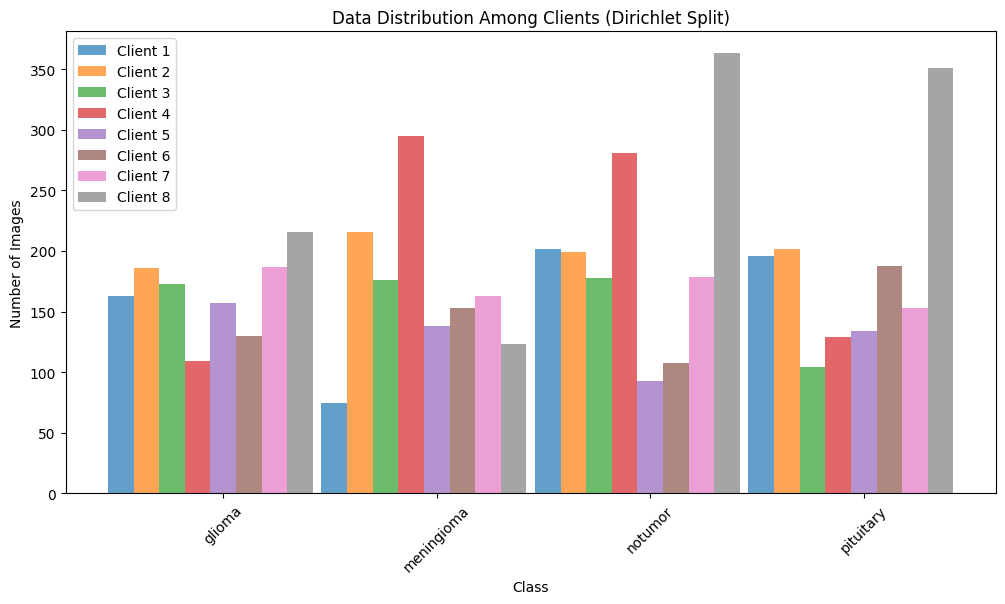

In [ ]:
# Apply Dirichlet-based splitting
print(" Splitting dataset...")
start_time = time.time()
client_datasets, client_indices = dirichlet_split_noniid(train_dataset, config["num_clients"], alpha=config["dir_alpha"])
end_time = time.time()
print(f" Dataset successfully split in {end_time - start_time:.2f} seconds.")

# Plot data distribution
plot_client_data_distribution(client_indices, np.array([label for _, label in train_dataset.samples]), train_dataset, config["num_clients"])


## Display data splits

In [ ]:
#show the data splits of each client in numbers
for i, client_dataset in enumerate(client_datasets):
    class_counts = defaultdict(int)
    for _, label in client_dataset:
        class_counts[train_dataset.classes[label]] += 1

    print(f"Client {i+1}:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")


Client 1:
  glioma: 163 images
  meningioma: 75 images
  notumor: 202 images
  pituitary: 196 images
Client 2:
  glioma: 186 images
  meningioma: 216 images
  notumor: 199 images
  pituitary: 202 images
Client 3:
  glioma: 173 images
  meningioma: 176 images
  notumor: 178 images
  pituitary: 104 images
Client 4:
  glioma: 109 images
  meningioma: 295 images
  notumor: 281 images
  pituitary: 129 images
Client 5:
  glioma: 157 images
  meningioma: 138 images
  notumor: 93 images
  pituitary: 134 images
Client 6:
  glioma: 130 images
  meningioma: 153 images
  notumor: 108 images
  pituitary: 188 images
Client 7:
  glioma: 187 images
  meningioma: 163 images
  notumor: 179 images
  pituitary: 153 images
Client 8:
  glioma: 216 images
  meningioma: 123 images
  notumor: 363 images
  pituitary: 351 images


## creates DataLoaders for both the federated clients and the test dataset.

Uses a list comprehension to create a DataLoader for each client_data.

In [ ]:
client_loaders = [DataLoader(client_data, batch_size=config["batch_size"], shuffle=True) for client_data in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
print("DataLoaders ready!")

DataLoaders ready!


## the CNN Model

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


## Fed_Average
This function correctly implements Federated Averaging (FedAvg) by averaging the model weights without modifying the original models.

In [ ]:
def fed_avg(models):
    """
    Takes a list of trained local models and averages their weights to update the global model.
    returns Aggregated global model with averaged weights
    """
    model_weights = [m.state_dict() for m in models]  # Extracts model weights (state_dict) from each client model
    avg_weights = copy.deepcopy(model_weights[0])  # Create a copy of the first model’s weights , so it doesnt change the original

    for key in avg_weights.keys():
        for i in range(1, len(model_weights)):
            avg_weights[key] += model_weights[i][key]  # Sum weights
        avg_weights[key] = torch.div(avg_weights[key], len(model_weights))  # Average

    global_model = copy.deepcopy(models[0])  # Copy one model as global model
    global_model.load_state_dict(avg_weights)  # Load averaged weights
    return global_model



## training
 trains a local client model for one epoch and computes key performance metrics.

In [ ]:
def train(model, dataloader, optimizer, criterion):
    """Train a local model for one epoch and compute metrics"""
    model.train()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in dataloader:
        images, labels = images.to(config["device"]), labels.to(config["device"])  # Move to device

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())  # Move to CPU before .numpy()
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    return total_loss / len(dataloader), accuracy, precision, recall, f1


## Testing
evaluates the global model on the test dataset and computes key performance metrics.

In [ ]:
def test(model, dataloader, criterion):
    """Evaluate the global model on the test dataset and compute metrics"""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(config["device"]), labels.to(config["device"])  # Move to correct device

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())  # Move to CPU before .numpy()
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    return total_loss / len(dataloader), accuracy, precision, recall, f1


initializes the global model, loss function, and tracking lists for training history.

In [ ]:
# Initialize global model and loss function
global_model = BrainTumorCNN(num_classes=config["num_classes"]).to(config["device"]) # Move the global model to the device
criterion = nn.CrossEntropyLoss()

# Initialize lists to store training history
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_f1, test_f1 = [], []


## **Federated Learning Setup - server side**

Server (Central Aggregator) → Collects client models, aggregates them (FedAvg), and distributes the updated model.

In [ ]:
print("\nStarting Federated Learning...")
client_train_history = {i: {"accuracy": [], "loss": [], "precision": [], "recall": [], "f1": []} for i in range(config["num_clients"])}  # Moved outside loop

for round in range(config["num_rounds"]):
    print(f"\n Round {round+1}")

    local_models = []
    round_train_losses, round_train_accuracy = [], []
    round_train_precision, round_train_recall, round_train_f1 = [], [], []
    client_data_sizes = []  # Correctly reset every round

    # Train clients
    for i, dataloader in enumerate(client_loaders):
        client_model = BrainTumorCNN(num_classes=config["num_classes"])
        client_model.load_state_dict(global_model.state_dict())  # Sync with global model
        client_model.to(config["device"])  # Move client model to GPU <--- This line was added

        optimizer = optim.Adam(client_model.parameters(), lr=config["learning_rate"])
        loss, acc, prec, rec, f1 = train(client_model, dataloader, optimizer, criterion)

        local_models.append(client_model)

        # Store client metrics in history dictionary
        client_train_history[i]["accuracy"].append(acc)
        client_train_history[i]["loss"].append(loss)
        client_train_history[i]["precision"].append(prec)
        client_train_history[i]["recall"].append(rec)
        client_train_history[i]["f1"].append(f1)

        #Append training results to round-specific lists
        round_train_losses.append(loss)
        round_train_accuracy.append(acc)
        round_train_precision.append(prec)
        round_train_recall.append(rec)
        round_train_f1.append(f1)
        client_data_sizes.append(len(dataloader.dataset))  #Store client dataset size

        print(f"Client {i+1} - Samples: {len(dataloader.dataset)}, Loss: {loss:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

    # Aggregate models using FedAvg
    global_model = fed_avg(local_models)

    #  Ensure `client_data_sizes` is not empty before division
    if sum(client_data_sizes) > 0:
        total_data = sum(client_data_sizes)
        avg_train_loss = sum([l * s for l, s in zip(round_train_losses, client_data_sizes)]) / total_data
        avg_train_acc = sum([a * s for a, s in zip(round_train_accuracy, client_data_sizes)]) / total_data
        avg_train_prec = sum([p * s for p, s in zip(round_train_precision, client_data_sizes)]) / total_data
        avg_train_rec = sum([r * s for r, s in zip(round_train_recall, client_data_sizes)]) / total_data
        avg_train_f1 = sum([f * s for f, s in zip(round_train_f1, client_data_sizes)]) / total_data
    else:
        avg_train_loss = avg_train_acc = avg_train_prec = avg_train_rec = avg_train_f1 = 0  # Default to 0 if no data

    # Store aggregated global training metrics
    train_losses.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)
    train_precision.append(avg_train_prec)
    train_recall.append(avg_train_rec)
    train_f1.append(avg_train_f1)

    print(f"🌎 Global Model After Round {round+1}:")
    print(f"   Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}, Prec: {avg_train_prec:.4f}, Rec: {avg_train_rec:.4f}, F1: {avg_train_f1:.4f}")

    # Evaluate the global model on the test dataset
    global_loss, global_acc, global_prec, global_rec, global_f1 = test(global_model, test_loader, criterion)

    # Store test performance
    test_losses.append(global_loss)
    test_accuracy.append(global_acc)
    test_precision.append(global_prec)
    test_recall.append(global_rec)
    test_f1.append(global_f1)

    print(f"Global Model Performance on Test Set:")
    print(f"   Loss: {global_loss:.4f}, Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")



Starting Federated Learning...

 Round 1
Client 1 - Samples: 636, Loss: 1.8222, Acc: 0.5865, Prec: 0.5128, Rec: 0.5865, F1: 0.5399
Client 2 - Samples: 803, Loss: 1.5021, Acc: 0.5342, Prec: 0.5287, Rec: 0.5342, F1: 0.5243
Client 3 - Samples: 631, Loss: 1.6681, Acc: 0.5452, Prec: 0.5486, Rec: 0.5452, F1: 0.5451
Client 4 - Samples: 814, Loss: 1.5462, Acc: 0.5098, Prec: 0.4966, Rec: 0.5098, F1: 0.4803
Client 5 - Samples: 522, Loss: 2.0048, Acc: 0.4943, Prec: 0.4993, Rec: 0.4943, F1: 0.4933
Client 6 - Samples: 579, Loss: 1.9467, Acc: 0.5130, Prec: 0.4876, Rec: 0.5130, F1: 0.4788
Client 7 - Samples: 682, Loss: 2.2400, Acc: 0.4120, Prec: 0.4305, Rec: 0.4120, F1: 0.3941
Client 8 - Samples: 1053, Loss: 1.0764, Acc: 0.6904, Prec: 0.6608, Rec: 0.6904, F1: 0.6693
🌎 Global Model After Round 1:
   Loss: 1.6628, Acc: 0.5462, Prec: 0.5303, Rec: 0.5462, F1: 0.5258
Global Model Performance on Test Set:
   Loss: 1.0360, Acc: 0.6117, Prec: 0.6218, Rec: 0.6117, F1: 0.5803

 Round 2
Client 1 - Samples: 636

## Report

In [ ]:
import pandas as pd

# Convert recorded test metrics into a Pandas DataFrame
test_metrics_df = pd.DataFrame({
    "Round": list(range(1, len(test_accuracy) + 1)),
    "Test Loss": test_losses,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1": test_f1
})

# Find the round with the best test accuracy
best_round = test_metrics_df["Test Accuracy"].idxmax()
best_accuracy = test_metrics_df.loc[best_round, "Test Accuracy"]

print(f"🏆 Best Model Found at Round {best_round+1} with Accuracy: {best_accuracy:.4f}")

# Retrieve the best model's metrics
best_model_metrics = test_metrics_df.loc[best_round]
print("\n Best Model Metrics:\n", best_model_metrics)

# Save the best model if it's better than the previous best
if best_accuracy > 0.0:  # Ensure at least one model has been tested
    best_model = global_model.state_dict()  # Save best model weights
    torch.save(best_model, "best_federated_model.pth")
    print(f"\n Best Model Saved with Accuracy: {best_accuracy:.4f}")
else:
    print("\n No valid best model found.")



🏆 Best Model Found at Round 20 with Accuracy: 0.9359

 Best Model Metrics:
 Round             20.000000
Test Loss          0.187554
Test Accuracy      0.935927
Test Precision     0.935795
Test Recall        0.935927
Test F1            0.935430
Name: 19, dtype: float64

 Best Model Saved with Accuracy: 0.9359


In [ ]:
# Create DataFrames for train metrics
train_metrics_df = pd.DataFrame({
    "Round": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Train Accuracy": train_accuracy,
    "Train Precision": train_precision,
    "Train Recall": train_recall,
    "Train F1 Score": train_f1
})


# Display DataFrames
print("Train Metrics:")
print(train_metrics_df)


Train Metrics:
    Round  Train Loss  Train Accuracy  Train Precision  Train Recall  \
0       1    1.662764        0.546154         0.530337      0.546154   
1       2    0.747199        0.712762         0.700104      0.712762   
2       3    0.591461        0.777273         0.771197      0.777273   
3       4    0.525409        0.811888         0.807306      0.811888   
4       5    0.474734        0.833392         0.830092      0.833392   
5       6    0.424676        0.842308         0.839172      0.842308   
6       7    0.403107        0.855594         0.853675      0.855594   
7       8    0.367974        0.872203         0.870493      0.872203   
8       9    0.349703        0.876748         0.875223      0.876748   
9      10    0.319912        0.886888         0.885539      0.886888   
10     11    0.314315        0.889860         0.888435      0.889860   
11     12    0.292322        0.900524         0.899632      0.900524   
12     13    0.274595        0.904545         0.9

saving the model in drive + saving metrics

In [ ]:
# Save training metrics as CSV
train_metrics_df.to_csv("federated_train_metrics.csv", index=False)

# Save test metrics as CSV
test_metrics_df.to_csv("federated_test_metrics.csv", index=False)


In [ ]:
# Save to Drive
torch.save(best_model, "/content/drive/My Drive/best_federated_model.pth")

train_metrics_df.to_csv("/content/drive/My Drive/federated_train_metrics.csv", index=False)
test_metrics_df.to_csv("/content/drive/My Drive/federated_test_metrics.csv", index=False)

# **Plotting**

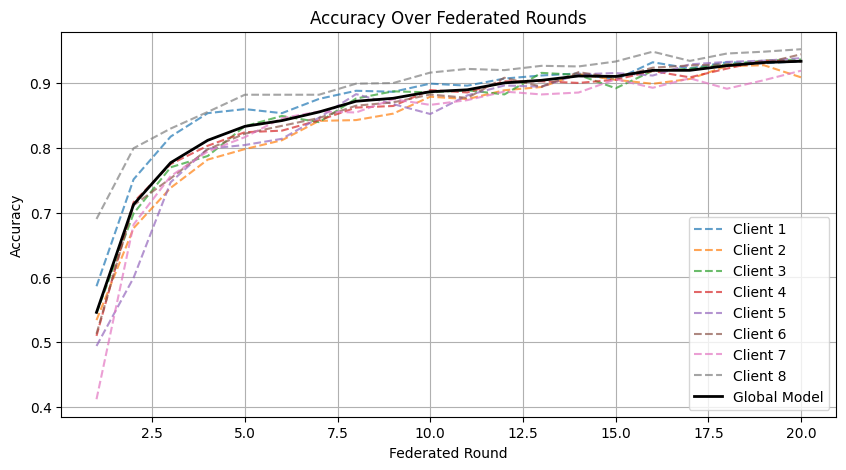

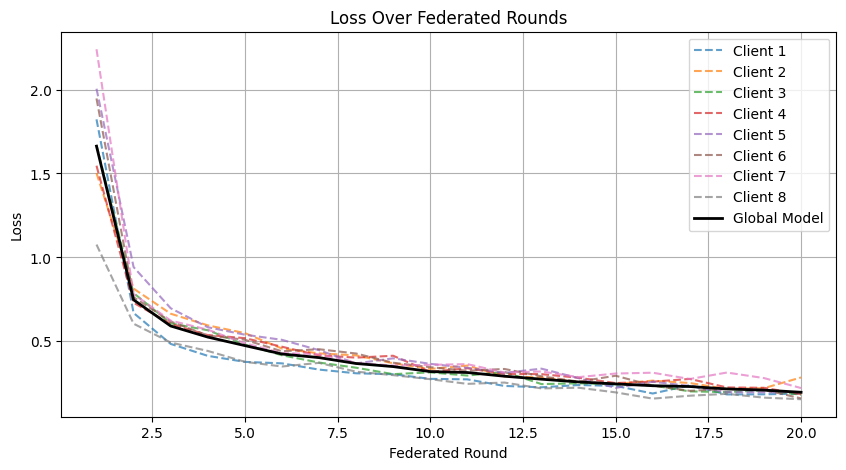

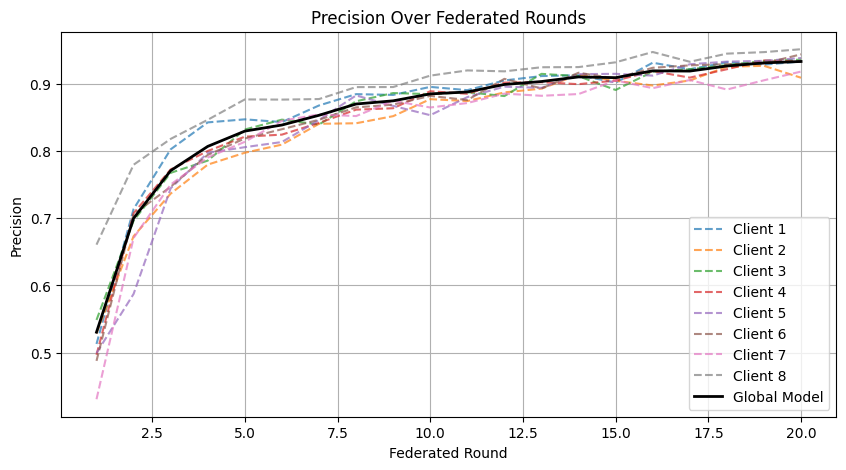

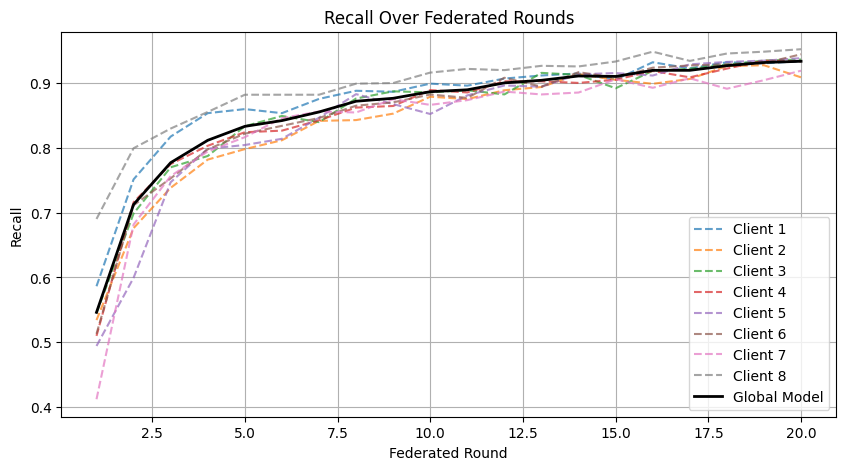

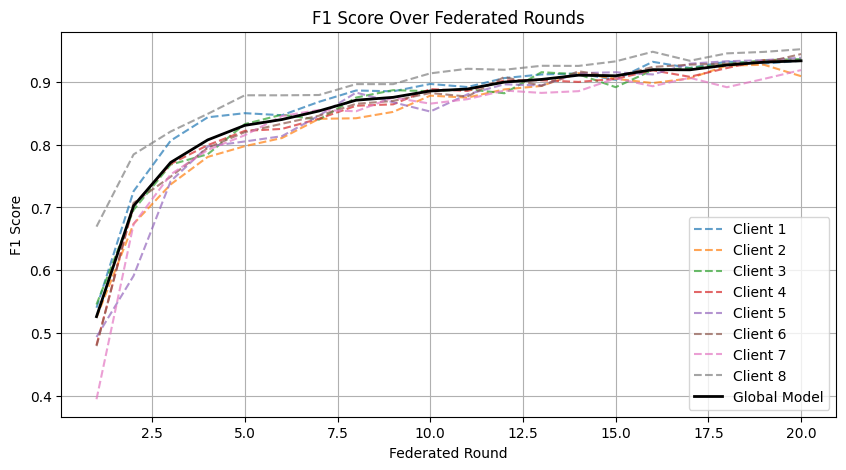

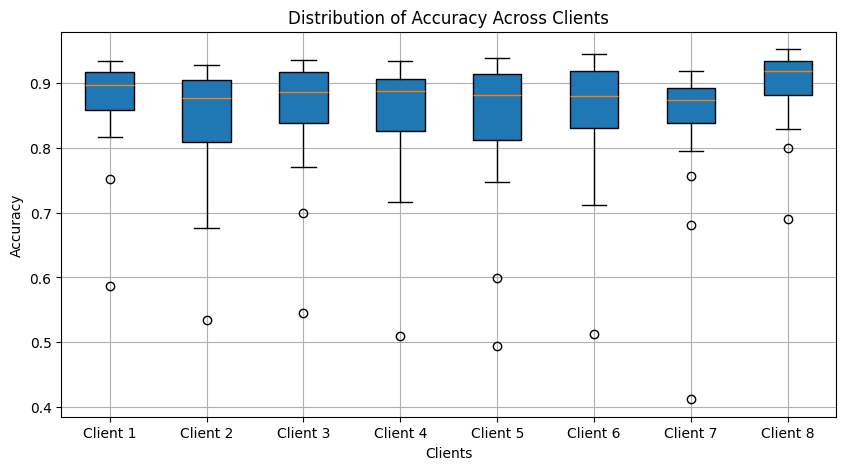

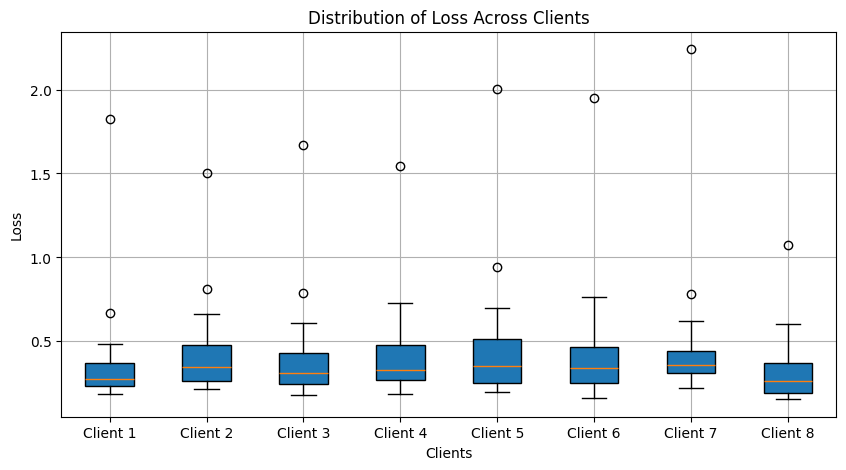

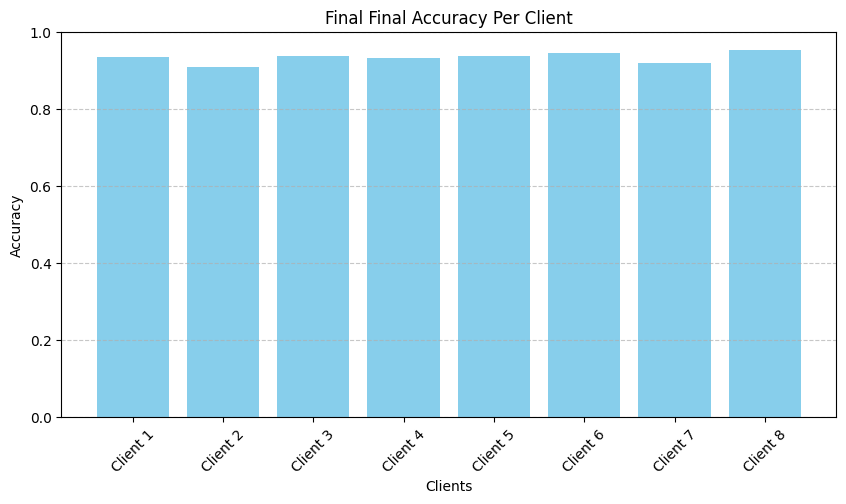

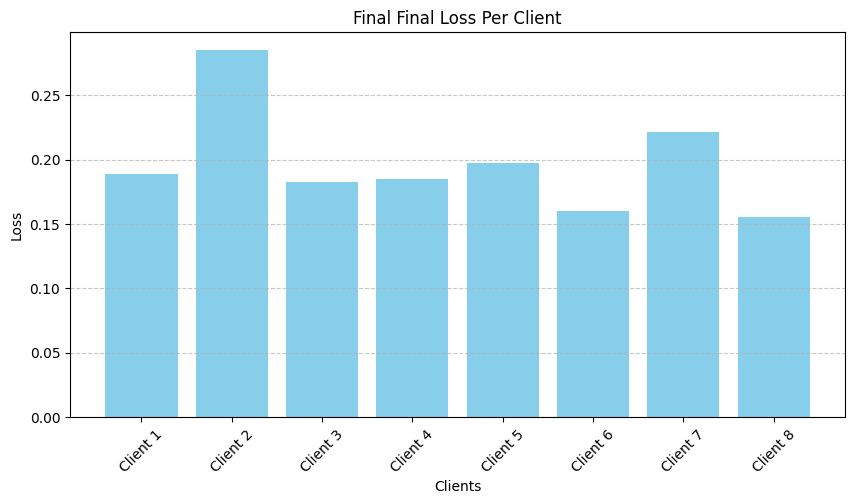

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot metrics over rounds
def plot_metric(metric_name, client_values, global_values, ylabel):
    plt.figure(figsize=(10, 5))

    # Plot each client's metric (stored per round)
    for client_id, values in enumerate(client_values):
        rounds = list(range(1, len(values) + 1))
        plt.plot(rounds, values, label=f"Client {client_id+1}", linestyle="dashed", alpha=0.7)

    # Plot global model metric
    plt.plot(range(1, len(global_values) + 1), global_values, label="Global Model", linewidth=2, color="black")

    plt.xlabel("Federated Round")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} Over Federated Rounds")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

#  Box plot function to compare final metrics across clients
def box_plot_metric(metric_name, client_values, ylabel):
    plt.figure(figsize=(10, 5))
    plt.boxplot(client_values, vert=True, patch_artist=True)
    plt.xlabel("Clients")
    plt.ylabel(ylabel)
    plt.title(f"Distribution of {metric_name} Across Clients")
    plt.xticks(range(1, len(client_values) + 1), [f"Client {i+1}" for i in range(len(client_values))])
    plt.grid(True)
    plt.show()

#  Bar chart to compare final performance of each client
def bar_plot_metric(metric_name, client_values, ylabel):
    plt.figure(figsize=(10, 5))
    avg_final_values = [values[-1] for values in client_values]  # Take last round value
    clients = [f"Client {i+1}" for i in range(len(client_values))]

    plt.bar(clients, avg_final_values, color="skyblue")
    plt.xlabel("Clients")
    plt.ylabel(ylabel)
    plt.title(f"Final {metric_name} Per Client")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

#  Extract per-client data for each metric
client_train_acc = [client_train_history[i]["accuracy"] for i in client_train_history]
client_train_loss = [client_train_history[i]["loss"] for i in client_train_history]
client_train_prec = [client_train_history[i]["precision"] for i in client_train_history]
client_train_rec = [client_train_history[i]["recall"] for i in client_train_history]
client_train_f1 = [client_train_history[i]["f1"] for i in client_train_history]

#  Plot metrics over federated rounds
plot_metric("Accuracy", client_train_acc, train_accuracy, "Accuracy")
plot_metric("Loss", client_train_loss, train_losses, "Loss")
plot_metric("Precision", client_train_prec, train_precision, "Precision")
plot_metric("Recall", client_train_rec, train_recall, "Recall")
plot_metric("F1 Score", client_train_f1, train_f1, "F1 Score")

#  Compare final client performances
box_plot_metric("Accuracy", client_train_acc, "Accuracy")
box_plot_metric("Loss", client_train_loss, "Loss")

bar_plot_metric("Final Accuracy", client_train_acc, "Accuracy")
bar_plot_metric("Final Loss", client_train_loss, "Loss")


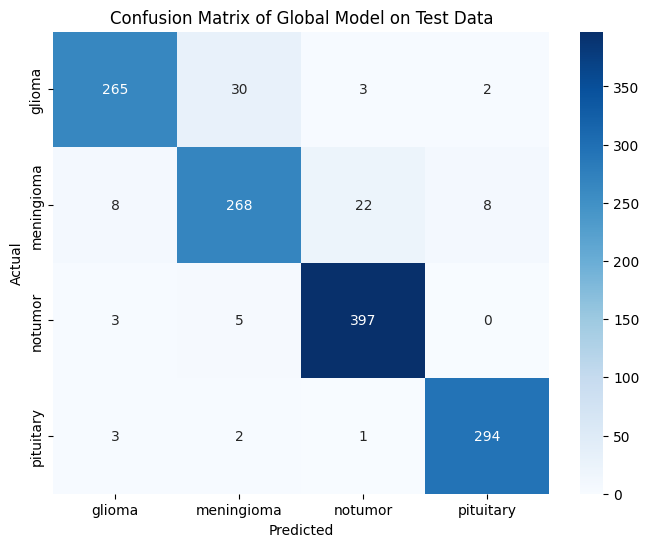

In [ ]:

# Get ground truth labels and predictions from test set
true_labels, pred_labels = [], []
global_model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(config["device"]), labels.to(config["device"])
        outputs = global_model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

#  Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(conf_matrix, index=train_dataset.classes, columns=train_dataset.classes)

#  Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Global Model on Test Data")
plt.show()

